# 动态定价模型模拟实验

## 价格需求模型
价格越低，购买的可能性越高。假设价格的选项为30，50，60，70，100，而且最低的购买可能性为100%，最高的可能性为10%，下面计算了中间价格对应的购买可能性

Price	Percentage
30.0	1.0
50.0	0.728571428571
60.0	0.592857142857
70.0	0.457142857143
100.0	0.05
[30.0, 50.0, 60.0, 70.0, 100.0]
[1.0, 0.7285714285714286, 0.5928571428571429, 0.4571428571428572, 0.050000000000000044]


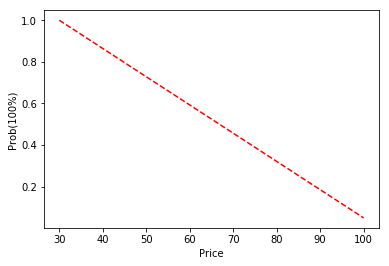


Test price and rewards
Price	Reward
70.0	0.0
100.0	0.0
50.0	0.0
30.0	0.0
30.0	0.0


In [4]:
import numpy as np

class LinearPriceModel(object):
    def __init__(self, start_percent, end_percent, prices):
        self.start_percent = start_percent
        self.end_percent = end_percent
        self.prices = prices
        
        self.start_price = self.prices[0]
        self.end_price = self.prices[-1]
        
        self.delta_price = self.prices[-1] - self.prices[0] #end_price - start_price
        #_, percentages = self.linear_price_model(self.start_percent,self.end_percent,self.prices)
        #self.percentages = percentages
        
    def get_demand_prob(self,price):
        return self.start_percent + \
            float(self.end_percent - self.start_percent) * (price - self.start_price)/self.delta_price
    
    def get_reward(self, price):
        # Given price, decide whether user will buy it or not
        # Return the reward, zero or the given price
        prob = self.get_demand_prob(price)/100.0
        r = np.random.rand()
        #print("r={},p={}".format(prob,r))
        if r < prob:
            return price
        return 0.0
    
class ManualPriceModel(object):
    def __init__(self, prices, probs):
        self.prices = prices
        self.probs = probs
        
    def get_demand_prob(self,price):
        for p, prob in zip(self.prices, self.probs):
            #print("p={},prob={},price={}".format(p,prob,price))
            if p == price:
                return prob
        return 0.0
    
    def get_reward(self, price):
        # Given price, decide whether user will buy it or not
        # Return the reward, zero or the given price
        prob = self.get_demand_prob(price)/100.0
        r = np.random.rand()
        #print("r={},p={}".format(prob,r))
        if r < prob:
            return price
        return 0.0

prices = [30.0,50.0,60.0,70.0,100.0]
m_probs = [10,8,5,2,0.1]
linear_model = LinearPriceModel(1, 0.05, prices)
manual_model = ManualPriceModel(prices,m_probs)

price_model = manual_model
price_model = linear_model

print("Price\tPercentage")
for price in prices:
    percentage = linear_model.get_demand_prob(price)
    print("{}\t{}".format(price,percentage))
    
# Visualize Demand Price Model: Price and Prob
probs = [price_model.get_demand_prob(price) for price in prices]
print(prices)
print(probs)
import matplotlib.pyplot as plt

%matplotlib inline

def show_price_model(prices,probs):
    global plt
    #plt.tilte('Price Demand Mode')
    plt.xlabel(u'Price')  
    plt.ylabel(u'Prob(100%)')
    idxes = range(len(prices))
    plt.plot(prices,probs,r'r--')
    plt.show()

show_price_model(prices,probs)

class RandomPricePolicy(object):
    def __init__(self, prices):
        self.prices = prices
    
    def get_price(self):
        price = np.random.choice(prices)
        return price
    
np.random.seed(1024) 
random_policy = RandomPricePolicy(prices)
print("\nTest price and rewards")
print("Price\tReward")
for _ in range(5):
    price = random_policy.get_price()
    reward = linear_model.get_reward(price)
    print("{}\t{}".format(price,reward))
    

## 随机定价策略

针对每个到来的用户，随机给定一个价格，并且按照上面的价格需求模型，计算最后的利润。
下面模拟一共10万个用户，计算它的平均利润

Total rewards:28480.0, Total_users:100000, Average Reward:0.2848


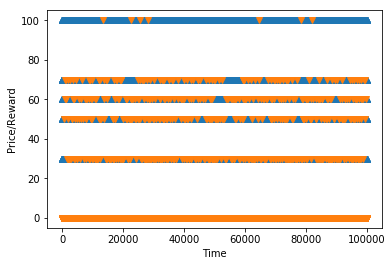

In [5]:

    
np.random.seed(1024) 

random_policy = RandomPricePolicy(prices)

total_users = 100000
total_rewards = 0.0
given_prices = []
receive_rewards = []
for _ in range(total_users):
    price = random_policy.get_price() 
    #total_rewards += linear_model.get_reward(price)
    reward = price_model.get_reward(price)
    total_rewards += reward
    given_prices.append(price)
    receive_rewards.append(reward)
    
avg_rewards = total_rewards / total_users
print("Total rewards:{}, Total_users:{}, Average Reward:{}".format(total_rewards, total_users, avg_rewards))

# Visualize reward and Price
def show_reward_price(prices,rewards):
    global plt
    #plt.tilte('Price Demand Mode')
    plt.xlabel(u'Time')  
    plt.ylabel(u'Price/Reward')
    idxes = range(len(prices))
    plt.plot(idxes,prices,'^',idxes,rewards,'v')
    plt.show()

show_reward_price(given_prices,receive_rewards)

## episilon-greedy策略


Total rewards:36820.0, Total_users:100000, Average Reward:0.3682


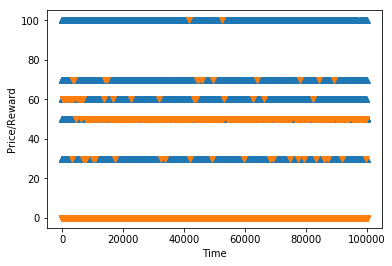

In [6]:
class GreedyPricePolicy(object):
    def __init__(self, prices, epsilon=0.1):
        self.prices = prices
        self.epsilon = epsilon
        
        self.rewards = [] #总回报
        self.nums = [] # 出价次数
        self.total_num = 0
        
        for idx, price in enumerate(prices):
            self.rewards.append(0.0)
            self.nums.append(0)
            
    def get_avg_reward(self, idx):
        num = self.nums[idx]
        reward = self.rewards[idx]
        
        if num <=0:
            avg = 0.0 #set maximum price
        else:
            avg = float(reward) / float(num)
            
        return avg 
    
    def get_price(self):
        r = np.random.rand()
        #print("r={},epsilon={}".format(r,self.epsilon))
        if r < self.epsilon:
            idx = np.random.choice(range(len(self.prices)))
            price = self.prices[idx]
            #print("idx={},price={}".format(idx,price))
            return price, idx
        
        # set one of random
        max_idx = np.random.choice(range(len(self.prices)))
        # Find max avg
        max_avg = self.get_avg_reward(max_idx)
        for idx, price in enumerate(self.prices):
            avg = self.get_avg_reward(idx)
            #print("idx={},price={},avg={}".format(idx,price,avg))
            if avg > max_avg:
                max_avg = avg
                max_idx = idx
                #print("==>max_reward={},max_idx={},price={}".format(max_avg,max_idx,price))
        price = self.prices[max_idx]
        #print("max_reward={},max_idx={},price={}".format(max_avg,max_idx,price))
        return price, max_idx
    
    def report_reward(self, idx, reward):
        #print("Report:idx={},reward={}".format(idx,reward))
        self.nums[idx] += 1
        self.total_num += 1
        self.rewards[idx] += reward
        

np.random.seed(1024) 

greedy_policy = GreedyPricePolicy(prices)

total_users = 100000
total_rewards = 0.0
receive_rewards=[]
given_prices=[]
for _ in range(total_users):
    price,idx = greedy_policy.get_price() 
    
    #reward = linear_model.get_reward(price)
    reward = price_model.get_reward(price)
    total_rewards += reward
    
    greedy_policy.report_reward(idx, reward)
    receive_rewards.append(reward)
    given_prices.append(price)
    
avg_rewards = total_rewards / total_users
print("Total rewards:{}, Total_users:{}, Average Reward:{}".format(total_rewards, total_users, avg_rewards))

# Visualize reward and Price

show_reward_price(given_prices,receive_rewards)

## UCB定价策略
每次选择ucb值最大的价格，ucb值定义为如下:

 $ucb = avg\_reward + sqrt(2*ln(n)/n_i)$
 
这里可能用到一个计算平均值的技巧： 
    $\bar{x} = x_k / k + \frac{(k-1)*\bar{x}_{k-1}}{k} $ 

Total rewards:37980.0, Total_users:100000, Average Reward:0.3798


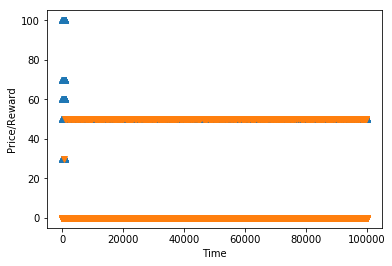

In [7]:
class UCBPricePolicy(object):
    def __init__(self, prices):
        self.prices = prices
        
        self.rewards = [] #总回报
        self.nums = [] # 出价次数
        self.total_num = 0
        
        for idx, price in enumerate(prices):
            self.rewards.append(0.0)
            self.nums.append(0)
            
    def get_ucb(self, idx):
        num = self.nums[idx]
        reward = self.rewards[idx]
        
        if num <=0:
            ucb = self.prices[-1] #set maximum price
        else:
            avg_reward = float(reward) / float(num)
            ucb = avg_reward
            ucb += np.sqrt(2*np.log(self.total_num)/float(num))
            
        return ucb 
    
    def get_price(self):
        # Find max ucb
        max_ucb = 0.0
        # set one of random
        max_idx = np.random.choice(range(len(self.prices)))
        for idx, price in enumerate(self.prices):
            ucb = self.get_ucb(idx)
            #print("idx={},price={},ucb={}".format(idx,price,ucb))
            if ucb > max_ucb:
                max_ucb = ucb
                max_idx = idx
        #print("max_ucb={},max_idx={}".format(max_ucb,max_idx))
        price = self.prices[max_idx]
        return price, max_idx
    
    def report_reward(self, idx, reward):
        #print("Report:idx={},reward={}".format(idx,reward))
        self.nums[idx] += 1
        self.total_num += 1
        self.rewards[idx] += reward
    
np.random.seed(1024) 

ucb_policy = UCBPricePolicy(prices)

total_users = 100000
total_rewards = 0.0
rewards=[]
given_prices=[]
for _ in range(total_users):
    price,idx = ucb_policy.get_price() 
    
    #reward = linear_model.get_reward(price)
    reward = price_model.get_reward(price)
    total_rewards += reward
    
    ucb_policy.report_reward(idx, reward)
    rewards.append(reward)
    given_prices.append(price)
    
avg_rewards = total_rewards / total_users
print("Total rewards:{}, Total_users:{}, Average Reward:{}".format(total_rewards, total_users, avg_rewards))
"""
for i in range(20):
    r = rewards[-i]
    p = given_prices[-i]
    print("{}\t{}".format(p,r))
"""
# Visualize reward and Price
show_reward_price(given_prices,rewards)

# UCB2算法
针对UCB1算法的改进。UCB1的缺点（1）最开始时置信区间波动比较大，经常选中比较差的item；  （2）所有item都要测试一遍，item数目较多时，比较浪费成本。


算法如下：下面代码循环

1）选择一个机器j, 使得 $\bar{x_j} + a_{n,r_j}$ 值最小，其中n为总实验次数，$a_{n,r_j}$定义为：$a_{n,r_j} = \sqrt{\frac{(1+\alpha)*ln(n/\tau{(r_j)})}{2*\tau{(r_j)}}}$. $\tau{(r)}= \lceil (1+\alpha)^r \rfloor$

 
2) 选择机器j $\tau{(r_j + 1)} - \tau{(r_j)}$次

3）$r_j = r_j + 1$

Total rewards:16190.0, Total_users:50000, Average Reward:0.3238


/home/clickwise/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:40: RuntimeWarning: invalid value encountered in sqrt


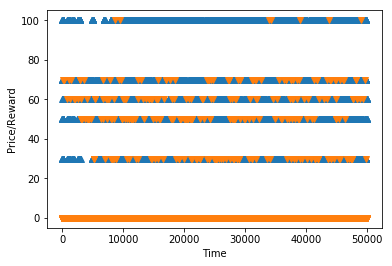

In [22]:
import math
import numpy as np

class UCB2PricePolicy(object):
    def __init__(self, prices):
        self.prices = prices
        
        self.state = 0 # 0 --- select, 1 ---- previous 3---
        
        self.alpha = 0.1
        # when in preivous(1) state, keep try some times
        self.tries = 0
        self.keep_idx = 0
        self.keep_price = 0.0
        self.max_tries = 0
        
        self.rewards = [] #总回报
        self.nums = [] # 出价次数
        self.rs = [] #  
        self.total_num = 0
        
        for idx, price in enumerate(prices):
            self.rewards.append(0.0)
            self.nums.append(0)
            self.rs.append(0)
            
    def tau(self, r):
        return int(math.pow(1+self.alpha,r))
    
    def get_ucb(self, idx):
        r = self.rs[idx]
        num = self.nums[idx]
        reward = self.rewards[idx]
        tau = self.tau(r)
        if num <=0: 
            ucb = np.sqrt((1+self.alpha)*np.log(math.e*(self.total_num+1.0)/tau)/float(2.0*tau))
        else:
            avg_reward = float(reward) / float(num)
            ucb = avg_reward
            delta= np.sqrt((1+self.alpha)*np.log(math.e*(self.total_num+1.0)/tau)/float(2.0*tau))
            ucb += delta
            #print("idx={},price={},ucb={},tau={},delta={},avg={},r={}".format(idx,self.prices[idx],ucb,tau,delta,avg_reward,r))
        return ucb 
    
    def get_price(self):          
        if self.state == 1:
            if self.tries < self.max_tries:
                self.tries += 1
                #print("Keep:idx={},price={},max_tries={},tries={}".format(self.keep_idx,self.keep_price,self.max_tries, self.tries))
                return self.keep_price, self.keep_idx
            
            self.rs[self.keep_idx] += 1
            #go to state 0
            self.state = 0
            
        if self.state == 0:
            # select machine with biggest ucb
            # Find max ucb
            #max_ucb = 0.0
            # set one of random
            max_idx = np.random.choice(range(len(self.prices)))
            max_ucb = self.get_ucb(max_idx)
            for idx, price in enumerate(self.prices):
                ucb = self.get_ucb(idx)
                #print("idx={},price={},ucb={}".format(idx,price,ucb))
                if ucb > max_ucb:
                    max_ucb = ucb
                    max_idx = idx
            #print("***max_ucb={},max_idx={},price={}".format(max_ucb,max_idx,self.prices[max_idx]))
            #Enter into state 1
            self.state = 1
            self.tries = 0
            self.keep_idx = max_idx
            price = self.prices[max_idx]
            self.keep_price = price
            
            r = self.rs[max_idx]
            self.max_tries = max(min(self.tau(r+1) - self.tau(r),20),0)
            #print("Keep:idx={},price={},max_tries={},tries={}".format(self.keep_idx,self.keep_price,self.max_tries, self.tries))
            
            return price, max_idx
    
    def report_reward(self, idx, reward):
        #print("Report:idx={},reward={}".format(idx,reward))
        self.nums[idx] += 1
        self.total_num += 1
        self.rewards[idx] += reward
    
np.random.seed(1024) 

ucb_policy = UCB2PricePolicy(prices)

total_users = 50000
total_rewards = 0.0
rewards=[]
given_prices=[]
for _ in range(total_users):
    price,idx = ucb_policy.get_price() 
    
    #reward = linear_model.get_reward(price)
    reward = price_model.get_reward(price)
    total_rewards += reward
    
    ucb_policy.report_reward(idx, reward)
    rewards.append(reward)
    given_prices.append(price)
    
avg_rewards = total_rewards / total_users
print("Total rewards:{}, Total_users:{}, Average Reward:{}".format(total_rewards, total_users, avg_rewards))
"""
for i in range(20):
    r = rewards[-i]
    p = given_prices[-i]
    print("{}\t{}".format(p,r))
"""
#print(given_prices)
# Visualize reward and Price
show_reward_price(given_prices,rewards)